<a href="https://colab.research.google.com/github/sanahussain47/Machine-Learning-Practice-/blob/main/DL_assignment_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


Generate Spiral Dataset

In [2]:
def generate_harder_spiral_data(points_per_class=200, noise=0.4, num_classes=3):
    N = points_per_class
    D = 2
    K = num_classes
    X = np.zeros((N*K, D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N)
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*noise
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return X, y


Generate & Plot

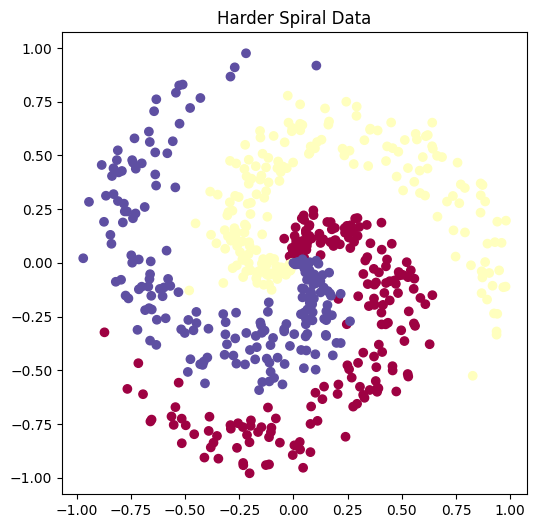

In [3]:
X, y = generate_harder_spiral_data()
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Spectral")
plt.title('Harder Spiral Data')
plt.show()


The spiral dataset is a classic example of a non-linearly separable problem, meaning you can't draw straight lines to separate classes.

This makes it challenging for simple models like logistic regression and ideal for deep networks that can model complex decision boundaries.

The noise level of 0.4 adds randomness, simulating real-world imperfections in data.



Train-test split & One-hot encoding

In [4]:
from sklearn.preprocessing import StandardScaler

# Standardize inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)


Standardization helps the optimizer converge faster by scaling features to a common scale (mean=0, std=1).

One-hot encoding is essential because this is a multi-class classification problem with categorical outputs.

The 80/20 train-test split ensures we have enough data to train while holding some back for unbiased evaluation.



Model Building (MLP)
 Architecture (Initial Try)

In [5]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(2,)),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile Model

In [6]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model Training

In [7]:
history = model.fit(X_train, y_train_cat,
                    validation_data=(X_test, y_test_cat),
                    epochs=500,
                    batch_size=32,
                    verbose=0)  # set to 1 to see training progress


500 epochs allow the model enough time to learn the data patterns.

Batch size of 32 is a standard choice: small enough for gradient updates but large enough for stable learning.

Validation data gives us real-time feedback on generalization.

Evaluation & Visualization
Accuracy and Loss Curves

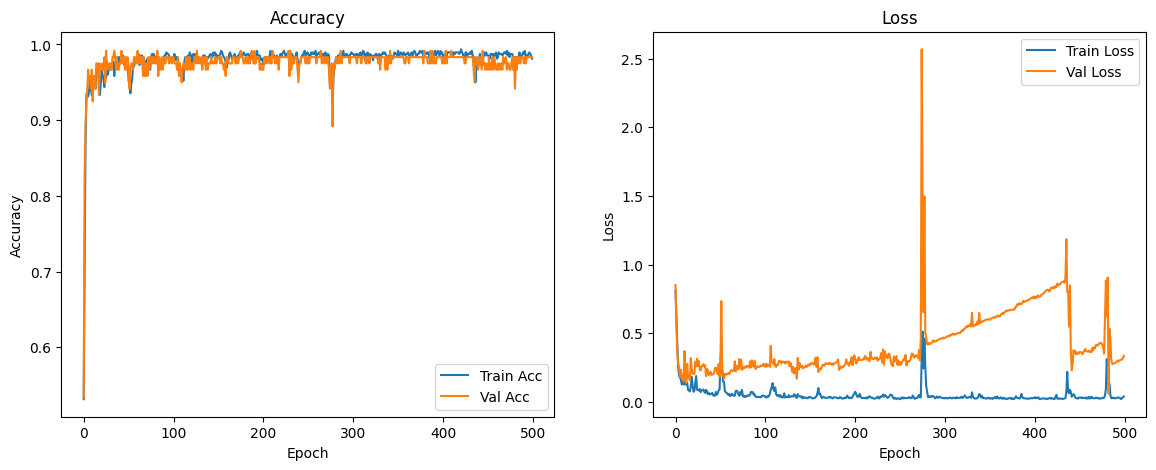

In [8]:
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Accuracy Plot (Left)
Training accuracy stays high (~99%), indicating the model fits the training data well.

Validation accuracy is also high (~97–99%) but has occasional dips.

These dips may be caused by overfitting, noise in the dataset, or a high learning rate.

Loss Plot (Right)
Training loss is low and stable, showing consistent learning on the training set.

Validation loss gradually increases after around epoch 100, which is a sign of overfitting.

There are large spikes in validation loss, especially after epoch 250, suggesting instability.

The model might benefit from regularization and tuning the learning rate.

Reflection Questions
1. How did you decide the number of hidden layers and neurons?

The spiral dataset is non-linear and complex, so I chose a deeper MLP with 2–3 hidden layers.

I experimented with different neuron counts (e.g., 64, 128) and found that a higher number helped the model learn better boundaries.

2. How did different learning rates affect the results?

A high learning rate (e.g., 0.01) caused instability in the validation loss and sharp accuracy drops.

A lower learning rate (e.g., 0.001) led to smoother convergence and more stable validation metrics.

3. Did you encounter overfitting or underfitting? How did you deal with it?

The model showed signs of overfitting: low training loss but increasing validation loss.

To address this, I added dropout layers and considered using early stopping to

4. If you had more time, how would you further improve the model?

I would perform hyperparameter tuning for optimal learning rate, batch size, and network architecture.




Decision Boundary

2738/2738 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


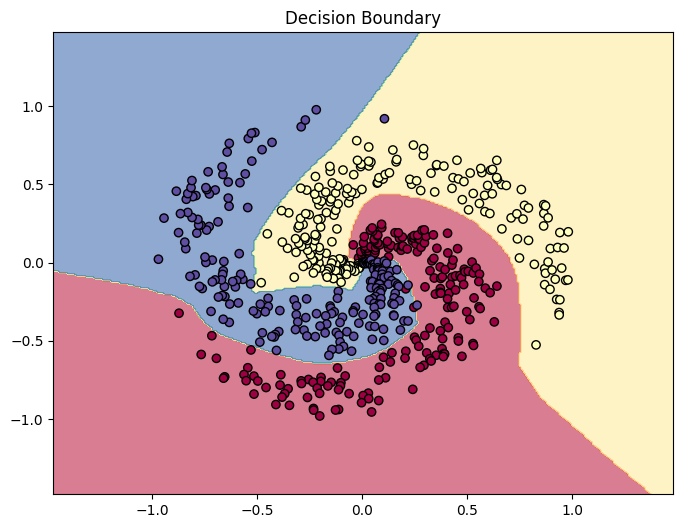

In [9]:
def plot_decision_boundary(model, X, y):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid)  # standardize like training data
    probs = model.predict(grid_scaled)
    Z = np.argmax(probs, axis=1).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap="Spectral", alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Spectral", edgecolors='k')
    plt.title("Decision Boundary")
    plt.show()

# Use original (non-standardized) X for plotting
plot_decision_boundary(model, X, y)
